In [1]:
from __future__ import print_function, division

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt

import sys

import numpy as np

In [2]:
class HyperParameters():
    epochs = 10000
    dataset = '2'
    batch_size = 100
    noise_size = 2
    seed = 1234
    n_samples = 1000
    sampling_size = 500
    # train/ not train
    training_status = 'train'
    # save/ load
    data_status = 'save'
    # write/ not
    writing_status = 'not'
params = HyperParameters

In [3]:
class GAN():
    def __init__(self):
        self.img_rows = 500
        self.img_cols = 2
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        gen_optimizer = Adam(0.01, 0.5)
        dis_optimizer = Adam(0.0002, 0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=dis_optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(1000,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

    def build_generator(self):

        noise_shape = (1000,)

        model = Sequential()

        model.add(Dense(32, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(16))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(4))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(16))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(4))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):
        params = HyperParameters()
        # Load the dataset
        X_train = np.load('y_train_{}.npy'.format(params.dataset))
        # Rescale -1 to 1

        half_batch = int(params.batch_size / 2)

        for epoch in range(params.epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

#             noise = np.random.multivariate_normal(mean=[0,0],cov=np.eye(2),size=(half_batch,params.sampling_size))
#             noise = np.reshape(noise,(half_batch,params.sampling_size*2))
            noise = np.random.uniform(0,1,size = (half_batch,params.sampling_size*2))
            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

#             noise = np.random.multivariate_normal(mean=[0,0],cov=np.eye(2),size=(params.batch_size,params.sampling_size))
#             noise = np.reshape(noise,(params.batch_size,params.sampling_size*2))
            noise = np.random.uniform(0,1,size = (params.batch_size,params.sampling_size*2))
            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * params.batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % 100 == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        noise = np.random.multivariate_normal(mean=[0,0],cov=np.eye(2),size=(params.batch_size,params.sampling_size))
        noise = np.reshape(noise,(params.batch_size,params.sampling_size*2))
        print(noise.shape)
        noise = np.random.uniform(0,1,size = (params.batch_size,params.sampling_size*2))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = np.reshape(gen_imgs[0],(params.sampling_size,2))
        
        # Rescale images 0 - 1

        plt.scatter(gen_imgs[:,0], gen_imgs[:,1], c='red', alpha=0.5)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim([-5, 5])
        plt.ylim([-5, 5])
        plt.show()
        if not os.path.exists("/imgs"):
            os.makedirs("/imgs")
        plt.savefig("/imgs/%d.png".format(epoch), dpi=300, bbox_inches='tight')


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, save_interval=200)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                16016     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 16,089
Trainable params: 16,089
Non-trainable params: 0
____________________________________________________

FileNotFoundError: [Errno 2] No such file or directory: 'y_train_2.npy'

In [7]:
samples = np.load('x_train_{}.npy'.format(params.dataset))
X_train = np.load('y_train_{}.npy'.format(params.dataset))

In [8]:
X_train = np.reshape(samples[2],(500,2))

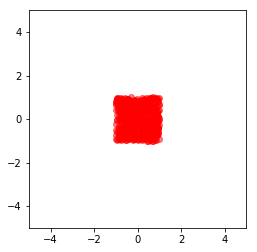

In [9]:
plt.scatter(X_train[:,0], X_train[:,1], c='red', alpha=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.show()